# XML Exploration
This notebook shows the typical structure of a *Chronicling America* OCR XML file. The schema with annotations can be found at https://schema.ccs-gmbh.com/ALTO. The page being analyzed here is the frontpage of the New York Tribune from April 20, 1906, which can be viewed as a PDF [on the LOC website](https://tile.loc.gov/storage-services/service/ndnp/dlc/batch_dlc_canada_ver01/data/sn83030214/00175041412/1906042001/0418.pdf).

## Imports

In [30]:
from xml.etree import ElementTree as ET # for parsing XML
from matplotlib import pyplot as plt    # for data visualization

## Globals
This cell defines global variables.

In [31]:
XML_PATH = './example_data/lccnsn830302141906-04-20ed-1seq-1.xml'
root = ET.parse(XML_PATH).getroot()

SCHEMA = '{http://schema.ccs-gmbh.com/ALTO}'

## Metadata
This group of cells reviews the metadata provided in the OCR XML file.

### Description
The `Description` tag contains information about the OCR processing pipeline used to produce the data.

In [32]:
description = root.find(f'{SCHEMA}Description') or ET.Element('')
print(f'OCR preprocessing software:', description[2][0][2][1].text)
print(f'OCR posprocessing software:', description[2][1][0][1].text)

OCR preprocessing software: CCS docWORKS
OCR posprocessing software: ABBYY FineReader Engine


### Styles
The `Styles` tag has a number of `TextStyle` subtags, each of which are referenced by at least one `TextBlock` (see below). Each `TextStyle` tag includes attributes for font size, family, and style.

In [33]:
styles = root.find(f'{SCHEMA}Styles') or ET.Element('')
print(f'Found {len(styles.findall(f"{SCHEMA}TextStyle"))} text styles in this document.')

Found 43 text styles in this document.


In [34]:
if (style := styles.find(f"{SCHEMA}TextStyle")) is not None:
    print(f'Example text style: {style.attrib}')

Example text style: {'ID': 'TXT_0', 'FONTSIZE': '15', 'FONTFAMILY': 'Times New Roman', 'FONTSTYLE': 'bold'}


`Styles` also contains a smaller number of `ParagraphStyle` subtags, which describe alignment.

In [35]:
print(f'Found {len(styles.findall(f"{SCHEMA}ParagraphStyle"))} paragraph styles in this document.')

Found 3 paragraph styles in this document.


In [36]:
if (style := styles.find(f"{SCHEMA}ParagraphStyle")) is not None:
    print(f'Example paragraph style: {style.attrib}')

Example paragraph style: {'ID': 'PAR_RIGHT', 'ALIGN': 'Right'}


### Layout Metadata
The `Layout` tag contains both metadata about the layout and the actual text elements. Its only child is a single `Page` element that includes the height and width of the document:

In [37]:
layout = root.find(f'{SCHEMA}Layout') or ET.Element('')
page = layout.find(f'{SCHEMA}Page') or ET.Element('')
print(f'Page attributes: {page.attrib}')

Page attributes: {'ID': 'P1', 'PHYSICAL_IMG_NR': '1', 'HEIGHT': '26529', 'WIDTH': '19038'}


`Page` first contains `Margin` tags, which describe the bounds of the `PrintSpace` (see below). As in the rest of the document, `HPOS` and `VPOS` refer respectively to the x and y coordinates of the top-left corner of the element.

In [38]:
for dir in ("Top", "Bottom", "Left", "Right"):
    if (margin := page.find(f"{SCHEMA}{dir}Margin")) is not None:
        print(f'{dir} magin attributes: {margin.attrib}')

Top magin attributes: {'ID': 'P1_TM00001', 'HPOS': '0', 'VPOS': '0', 'WIDTH': '19035', 'HEIGHT': '392'}
Bottom magin attributes: {'ID': 'P1_BM00001', 'HPOS': '0', 'VPOS': '26079', 'WIDTH': '19035', 'HEIGHT': '449'}
Left magin attributes: {'ID': 'P1_LM00001', 'HPOS': '0', 'VPOS': '392', 'WIDTH': '411', 'HEIGHT': '25687'}
Right magin attributes: {'ID': 'P1_RM00001', 'HPOS': '18534', 'VPOS': '392', 'WIDTH': '501', 'HEIGHT': '25687'}


The `PrintSpace` tag describes the area within the margins and contains the OCR data itself. As expected, the `HPOS` matches the size of the left margin and the `VPOS` matches the size of the top margin.

In [39]:
space = page.find(f'{SCHEMA}PrintSpace') or ET.Element('')
print(space.attrib)

{'ID': 'P1_PS00001', 'HPOS': '411', 'VPOS': '392', 'WIDTH': '18123', 'HEIGHT': '25687'}


## Text Data
Within `Printspace` are various text elements containing the OCR data itself. Its immediate chidlren are `TextBlock` elements, which describe an axis-aligned bounding box containing zero or more lines of text.

In [40]:
blocks = space.findall(f"{SCHEMA}TextBlock")
print(f'Found {len(blocks)} text blocks in this document.')

Found 69 text blocks in this document.


Some `TextBlock` tags do not contain text; these blocks have no children and no `STYLEREFS`.

In [41]:
print(f'Example of empty TextBlock:', blocks[0].attrib)

Example of empty TextBlock: {'ID': 'P1_TB00069', 'HPOS': '1672', 'VPOS': '392', 'WIDTH': '15345', 'HEIGHT': '1266'}


Most `TextBlock` tags have both a bounding box description and two `STYLEREFS`: one corresponing to a font style and one corresponding to a paragraph alignment.

In [42]:
print(f'Example of typical TextBlock:', blocks[1].attrib)

Example of typical TextBlock: {'ID': 'P1_TB00005', 'HPOS': '510', 'VPOS': '1682', 'WIDTH': '2263', 'HEIGHT': '241', 'STYLEREFS': 'TXT_5 PAR_LEFT'}


Nonempty text blocks contain one or more `TextLine` tags, each of which describes a bounding box containing a single line of text.

In [43]:
lines = []
for block in blocks:
    lines += block.findall(f'{SCHEMA}TextLine')

print(f'Found {len(lines)} text lines in this document.')

Found 685 text lines in this document.


A bar chart of the number of lines in each text block reflects the structure of the page. We can see shorter articles on the left, and the two columns of a long article on the right.

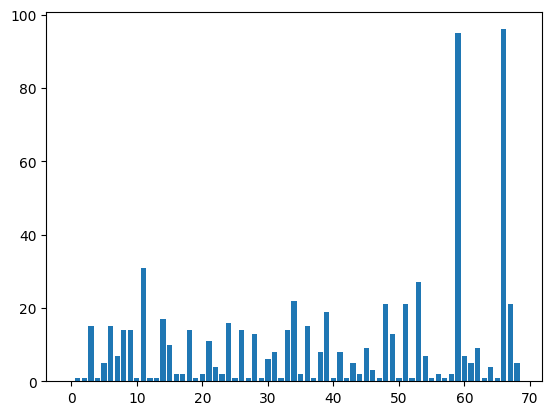

In [46]:
line_counts = [len(block.findall(f'{SCHEMA}TextLine')) for block in blocks]
plt.bar(list(range(len(line_counts))), (line_counts))
plt.show()

Each `TextLine` contains strings, spaces, and possibly hyphens. `String` tags describe a bounding box, its text content, and information about OCR confidence:
- `CONTENT` contains the text identified by OCR
- `WC` varies between zero and one and represents the OCR confidence for the whole string
- `CC` is a sequence of digits that vary between zero and nine, with each digit representing the OCR confidence for the corresponding character
- `STYLEREFS` refer to a `TextStyle` tag (see above), mostly for bold and italics

In [63]:
print('Example of typical String:', lines[5][2].attrib, sep='\n')

Example of typical String:
{'ID': 'P1_ST00108', 'HPOS': '1077', 'VPOS': '3652', 'WIDTH': '364', 'HEIGHT': '142', 'CONTENT': 'front', 'WC': '0.81', 'CC': '11116', 'STYLEREFS': 'TXT_6'}


In [57]:
string_wc = []
for line in lines:
    for string in line.findall(f'{SCHEMA}String'):
        string_wc.append(float(string.attrib['WC']))

print(f'Average OCR confidence across all strings:', sum(string_wc) / len(string_wc))

Average OCR confidence across all strings: 0.8789444329683841


`SP` tags describe a bounding box corresponding to a space between strings.

In [60]:
print('Example of typical space:', lines[5][1].attrib)

Example of typical space: {'ID': 'P1_SP00079', 'HPOS': '1020', 'VPOS': '3869', 'WIDTH': '57'}


The other possible subtag of a `TextLine` is a `HYP`, representing a hyphenated word broken up between lines. Whenever a `HYP` tag appears as the last child of one `TextLine`, it appears as the first child of another.

In [ ]:
print(f'End-of-line hyphen:  ', )
print(f'Start-of-line hyphen:', )